
**Install Required Libraries**


In [ ]:
!pip install imbalanced-learn -q
!pip install xgboost -q
!pip install pytorch-tabnet -q
!pip install shap -q
!pip install scikit-learn -q


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.4 MB/s eta 0:00:00


**Import Required Libraries**


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import torch

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, classification_report, confusion_matrix, brier_score_loss
)

from imblearn.over_sampling import SMOTE

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from pytorch_tabnet.tab_model import TabNetClassifier


**Upload and Load the Dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("diabetes.csv")
df.head()


Saving diabetes.csv to diabetes.csv


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


**Clean and Preprocess the Dataset**



In [ ]:
# Replace invalid zeros with median values
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for col in cols_with_zero:
    df[col] = df[col].replace(0, np.nan)
    df[col].fillna(df[col].median(), inplace=True)


/tmp/ipython-input-4-722440571.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)


**Normalize Features and Balance Classes**


In [ ]:
# Separate features and target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Normalize using QuantileTransformer
scaler = QuantileTransformer(output_distribution='normal')
X_scaled = scaler.fit_transform(X)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_scaled, y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)


/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_data.py:2829: UserWarning: n_quantiles (1000) is greater than the total number of samples (768). n_quantiles is set to n_samples.
  warnings.warn(


**KNN Classifier - Training and Hyperparameter Tuning**



In [ ]:
param_grid = {'n_neighbors': list(range(3, 21))}
grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='f1')
grid_knn.fit(X_train, y_train)

best_k = grid_knn.best_params_['n_neighbors']
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_knn = knn.predict(X_test)

print("Best k:", best_k)


Best k: 16


**Evaluate KNN Model**



In [ ]:
knn_acc = accuracy_score(y_test, y_knn)
knn_f1 = f1_score(y_test, y_knn)
knn_prec = precision_score(y_test, y_knn)
knn_recall = recall_score(y_test, y_knn)
knn_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
knn_brier = brier_score_loss(y_test, knn.predict_proba(X_test)[:, 1])

print(f"Accuracy     : {knn_acc:.4f}")
print(f"F1 Score     : {knn_f1:.4f}")
print(f"Precision    : {knn_prec:.4f}")
print(f"Recall       : {knn_recall:.4f}")
print(f"AUC Score    : {knn_auc:.4f}")
print(f"Brier Score  : {knn_brier:.4f}")


Accuracy     : 0.7850
F1 Score     : 0.8072
Precision    : 0.7377
Recall       : 0.8911
AUC Score    : 0.8465
Brier Score  : 0.1643


**KNN Confusion Matrix**

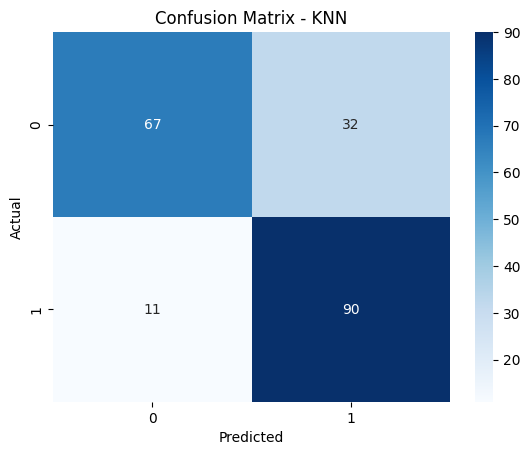

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_knn), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**Classification Report for KNN**

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report for KNN:")
print(classification_report(y_test, y_knn, digits=4))


Classification Report for KNN:
              precision    recall  f1-score   support

           0     0.8590    0.6768    0.7571        99
           1     0.7377    0.8911    0.8072       101

    accuracy                         0.7850       200
   macro avg     0.7983    0.7839    0.7821       200
weighted avg     0.7977    0.7850    0.7824       200



**ROC Curve for KNN**

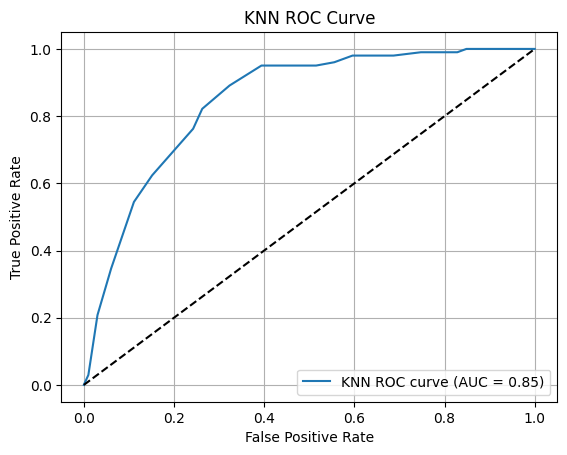

In [ ]:
from sklearn.metrics import roc_curve, auc

y_prob = knn.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'KNN ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('KNN ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Precision-Recall Curve for KNN**

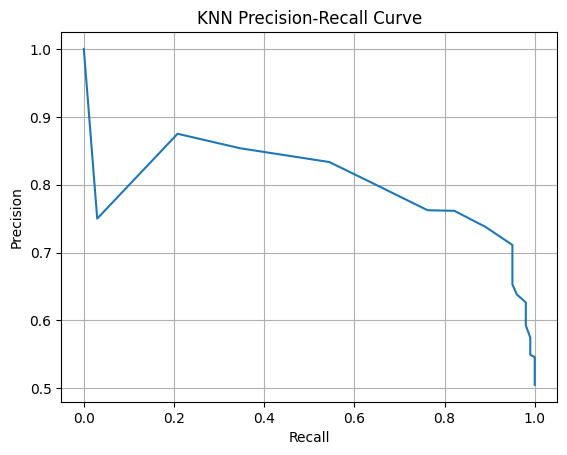

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('KNN Precision-Recall Curve')
plt.grid(True)
plt.show()


**Calibration Curve (Reliability Plot)**

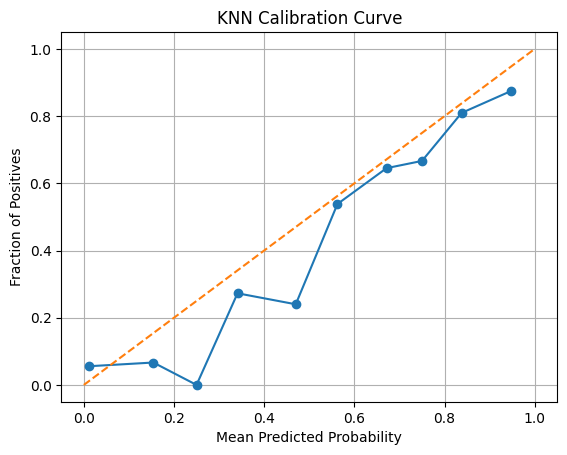

In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('KNN Calibration Curve')
plt.grid(True)
plt.show()


**Save KNN Model for Later Use**

In [ ]:
import joblib

joblib.dump(knn, "knn_diabetes_model.pkl")



['knn_diabetes_model.pkl']

**Complete Bernoulli Naive Bayes (BNB) Pipeline**


**Binarize Data (Required for BNB)**

In [ ]:
from sklearn.preprocessing import Binarizer

# Binarize continuous features to 0/1 for BernoulliNB
binarizer = Binarizer(threshold=0.0)
X_train_bin = binarizer.fit_transform(X_train)
X_test_bin = binarizer.transform(X_test)


**Train the BNB Model**

In [ ]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train_bin, y_train)

y_bnb = bnb.predict(X_test_bin)
y_bnb_proba = bnb.predict_proba(X_test_bin)[:, 1]  # Needed for AUC, Brier


**Evaluation Metrics**

In [ ]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, brier_score_loss
)

bnb_acc = accuracy_score(y_test, y_bnb)
bnb_f1 = f1_score(y_test, y_bnb)
bnb_prec = precision_score(y_test, y_bnb)
bnb_recall = recall_score(y_test, y_bnb)
bnb_auc = roc_auc_score(y_test, y_bnb_proba)
bnb_brier = brier_score_loss(y_test, y_bnb_proba)

print(f"Accuracy     : {bnb_acc:.4f}")
print(f"F1 Score     : {bnb_f1:.4f}")
print(f"Precision    : {bnb_prec:.4f}")
print(f"Recall       : {bnb_recall:.4f}")
print(f"AUC Score    : {bnb_auc:.4f}")
print(f"Brier Score  : {bnb_brier:.4f}")


Accuracy     : 0.6950
F1 Score     : 0.7053
Precision    : 0.6887
Recall       : 0.7228
AUC Score    : 0.7804
Brier Score  : 0.1982


**Confusion Matrix**

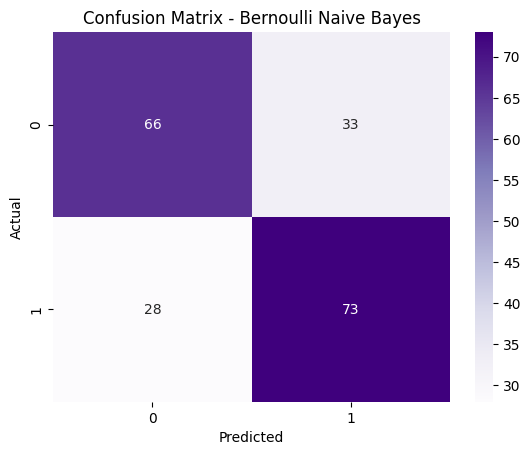

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(confusion_matrix(y_test, y_bnb), annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix - Bernoulli Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**ROC Curve**

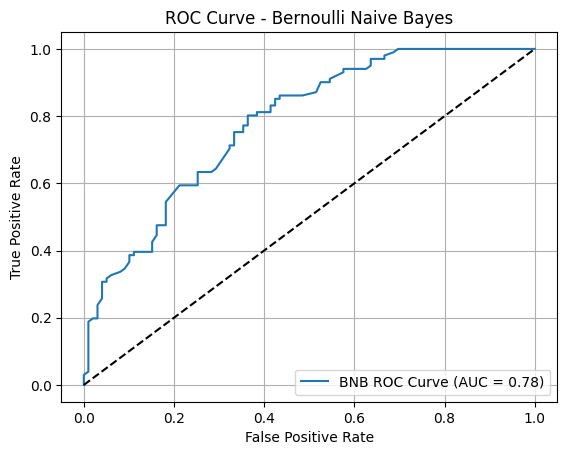

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_bnb_proba)
bnb_roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'BNB ROC Curve (AUC = {bnb_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Bernoulli Naive Bayes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


**Precision-Recall Curve**

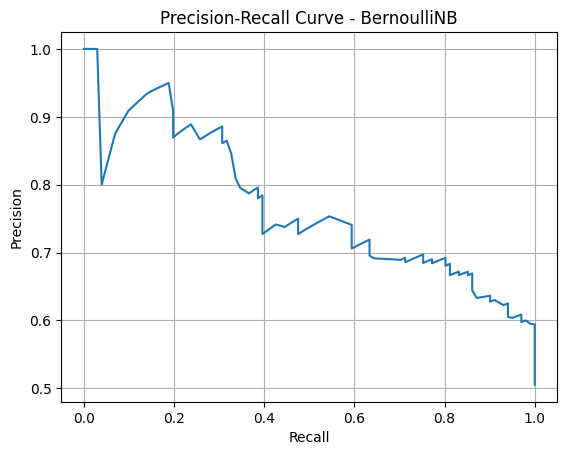

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_bnb_proba)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - BernoulliNB')
plt.grid(True)
plt.show()


**Calibration Curve (Reliability Plot)**



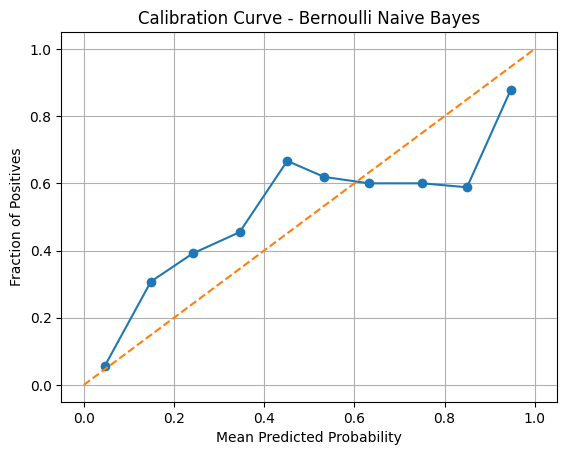

In [ ]:
from sklearn.calibration import calibration_curve

prob_true, prob_pred = calibration_curve(y_test, y_bnb_proba, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - Bernoulli Naive Bayes')
plt.grid(True)
plt.show()


**Classification Report**

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report - BernoulliNB:\n")
print(classification_report(y_test, y_bnb, digits=4))


Classification Report - BernoulliNB:

              precision    recall  f1-score   support

           0     0.7021    0.6667    0.6839        99
           1     0.6887    0.7228    0.7053       101

    accuracy                         0.6950       200
   macro avg     0.6954    0.6947    0.6946       200
weighted avg     0.6953    0.6950    0.6947       200



**Save the Trained Model**

In [ ]:
import joblib
joblib.dump(bnb, "bnb_diabetes_model.pkl")


['bnb_diabetes_model.pkl']

**Random Forest (RF) Classifier + SHAP Explainability**

**Train the Random Forest Model**


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)
rf.fit(X_train, y_train)

y_rf = rf.predict(X_test)
y_rf_proba = rf.predict_proba(X_test)[:, 1]


**Evaluate RF Model**


In [ ]:
rf_acc = accuracy_score(y_test, y_rf)
rf_f1 = f1_score(y_test, y_rf)
rf_prec = precision_score(y_test, y_rf)
rf_recall = recall_score(y_test, y_rf)
rf_auc = roc_auc_score(y_test, y_rf_proba)
rf_brier = brier_score_loss(y_test, y_rf_proba)

print(f"Accuracy     : {rf_acc:.4f}")
print(f"F1 Score     : {rf_f1:.4f}")
print(f"Precision    : {rf_prec:.4f}")
print(f"Recall       : {rf_recall:.4f}")
print(f"AUC Score    : {rf_auc:.4f}")
print(f"Brier Score  : {rf_brier:.4f}")


Accuracy     : 0.7850
F1 Score     : 0.7943
Precision    : 0.7685
Recall       : 0.8218
AUC Score    : 0.8920
Brier Score  : 0.1334


**Confusion Matrix**

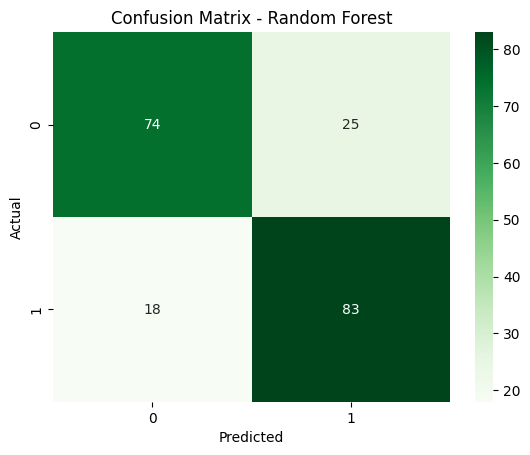

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_rf), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**ROC and Precision-Recall Curve**



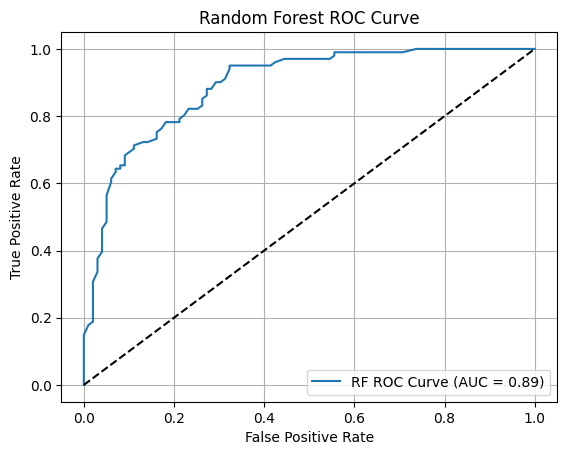

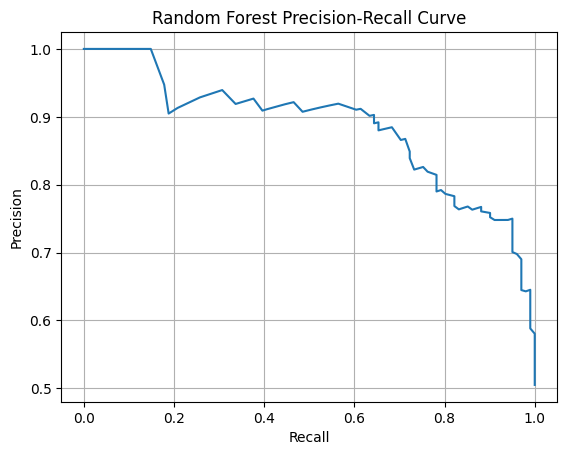

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_rf_proba)
plt.plot(fpr, tpr, label=f'RF ROC Curve (AUC = {rf_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_rf_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Random Forest Precision-Recall Curve')
plt.grid(True)
plt.show()


**Calibration Curve**

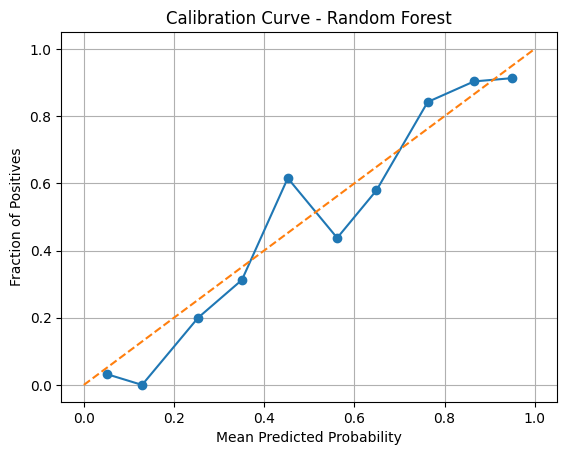

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, y_rf_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - Random Forest')
plt.grid(True)
plt.show()


**Classification Report**

In [ ]:
print("Classification Report - Random Forest:\n")
print(classification_report(y_test, y_rf, digits=4))


Classification Report - Random Forest:

              precision    recall  f1-score   support

           0     0.8043    0.7475    0.7749        99
           1     0.7685    0.8218    0.7943       101

    accuracy                         0.7850       200
   macro avg     0.7864    0.7846    0.7846       200
weighted avg     0.7863    0.7850    0.7847       200



**SHAP Explainability for Random Forest**



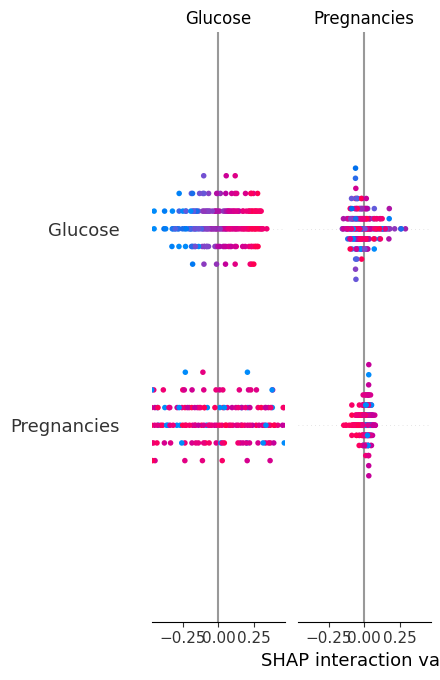

In [ ]:
import shap

# Create TreeExplainer
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

# Get feature names
feature_names = df.drop("Outcome", axis=1).columns

# SHAP summary plot (no indexing needed for RF)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)



**Save Random Forest Model**

In [ ]:
import joblib
joblib.dump(rf, "rf_diabetes_model.pkl")


['rf_diabetes_model.pkl']

**XGBoost Classifier + SHAP Explainability**

**Import and Initialize XGBoost Classifier**



In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    learning_rate=0.1,
    n_estimators=100,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train, y_train)
y_xgb = xgb.predict(X_test)
y_xgb_proba = xgb.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:56:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


**Evaluate XGBoost Model**

In [ ]:
xgb_acc = accuracy_score(y_test, y_xgb)
xgb_f1 = f1_score(y_test, y_xgb)
xgb_prec = precision_score(y_test, y_xgb)
xgb_recall = recall_score(y_test, y_xgb)
xgb_auc = roc_auc_score(y_test, y_xgb_proba)
xgb_brier = brier_score_loss(y_test, y_xgb_proba)

print(f"Accuracy     : {xgb_acc:.4f}")
print(f"F1 Score     : {xgb_f1:.4f}")
print(f"Precision    : {xgb_prec:.4f}")
print(f"Recall       : {xgb_recall:.4f}")
print(f"AUC Score    : {xgb_auc:.4f}")
print(f"Brier Score  : {xgb_brier:.4f}")


Accuracy     : 0.7950
F1 Score     : 0.8038
Precision    : 0.7778
Recall       : 0.8317
AUC Score    : 0.8547
Brier Score  : 0.1524


**Confusion Matrix**

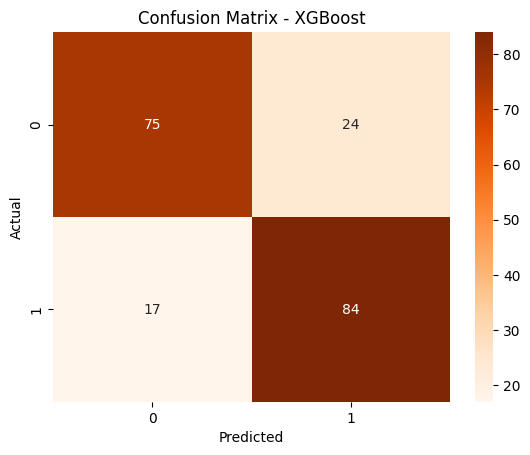

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_xgb), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**ROC & PR Curves**

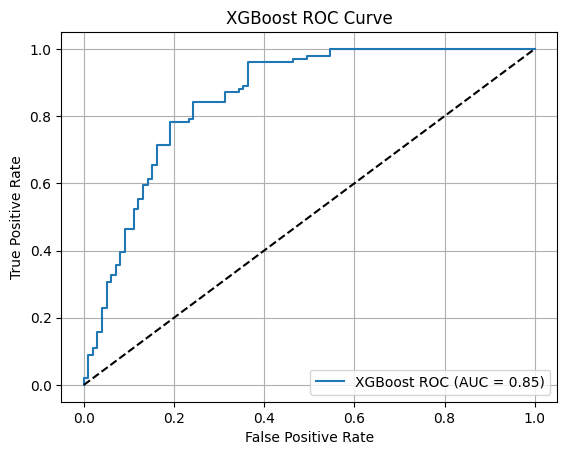

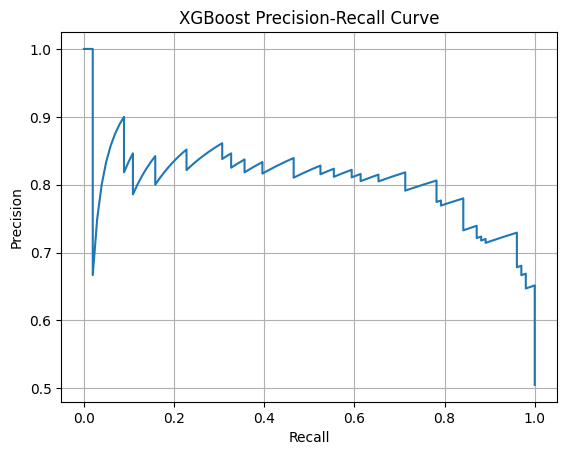

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_xgb_proba)
plt.plot(fpr, tpr, label=f'XGBoost ROC (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_xgb_proba)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XGBoost Precision-Recall Curve')
plt.grid(True)
plt.show()


**Calibration Curve**

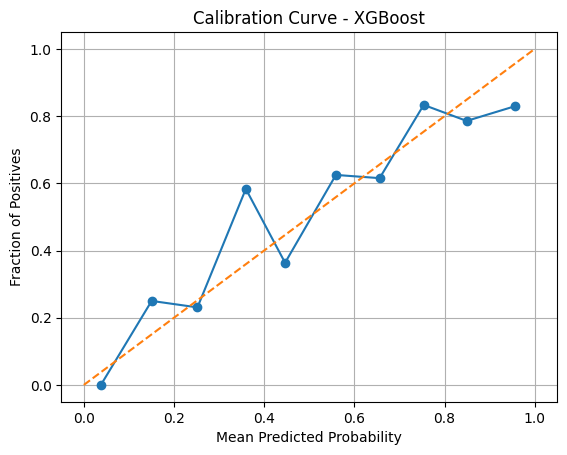

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, y_xgb_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - XGBoost')
plt.grid(True)
plt.show()


**SHAP Explainability**

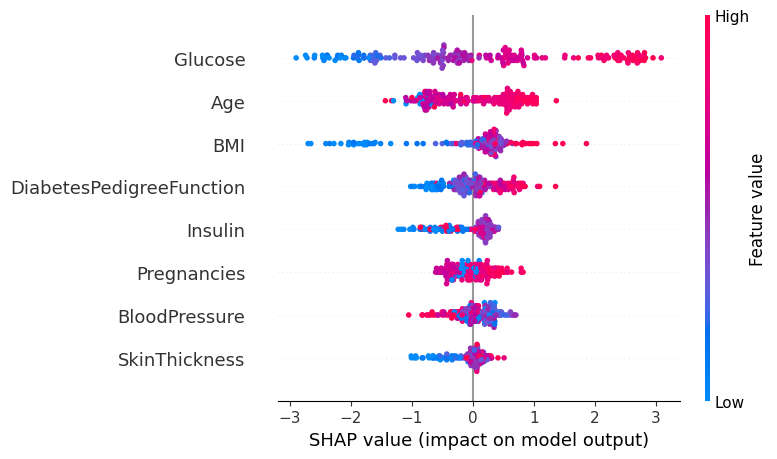

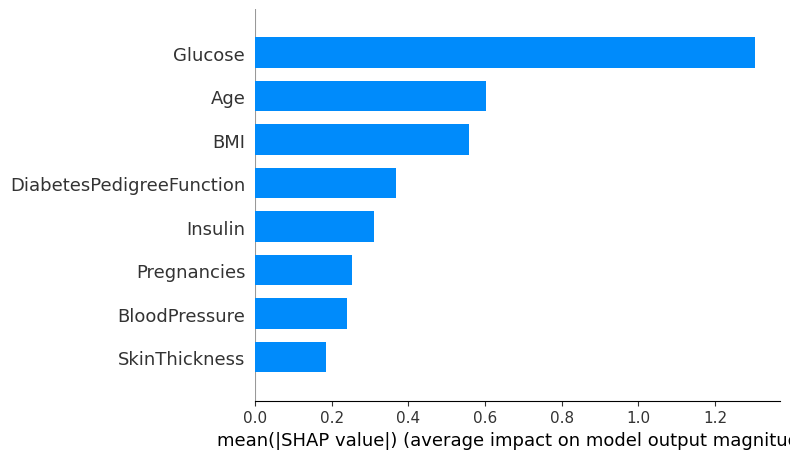

In [ ]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# Summary Plot
shap.summary_plot(shap_values, X_test, feature_names=df.drop("Outcome", axis=1).columns)

# Optional: Bar Plot
shap.summary_plot(shap_values, X_test, feature_names=df.drop("Outcome", axis=1).columns, plot_type='bar')


** Save XGBoost Model**

In [ ]:
joblib.dump(xgb, "xgb_diabetes_model.pkl")


['xgb_diabetes_model.pkl']

**Deep Neural Network (DNN) using MLPClassifier**

**Train the DNN Model**

In [ ]:
from sklearn.neural_network import MLPClassifier

dnn = MLPClassifier(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

dnn.fit(X_train, y_train)

y_dnn = dnn.predict(X_test)
y_dnn_proba = dnn.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


**Evaluate DNN Model**

In [ ]:
dnn_acc = accuracy_score(y_test, y_dnn)
dnn_f1 = f1_score(y_test, y_dnn)
dnn_prec = precision_score(y_test, y_dnn)
dnn_recall = recall_score(y_test, y_dnn)
dnn_auc = roc_auc_score(y_test, y_dnn_proba)
dnn_brier = brier_score_loss(y_test, y_dnn_proba)

print(f"Accuracy     : {dnn_acc:.4f}")
print(f"F1 Score     : {dnn_f1:.4f}")
print(f"Precision    : {dnn_prec:.4f}")
print(f"Recall       : {dnn_recall:.4f}")
print(f"AUC Score    : {dnn_auc:.4f}")
print(f"Brier Score  : {dnn_brier:.4f}")


Accuracy     : 0.8000
F1 Score     : 0.8131
Precision    : 0.7699
Recall       : 0.8614
AUC Score    : 0.8748
Brier Score  : 0.1463


**Confusion Matrix**

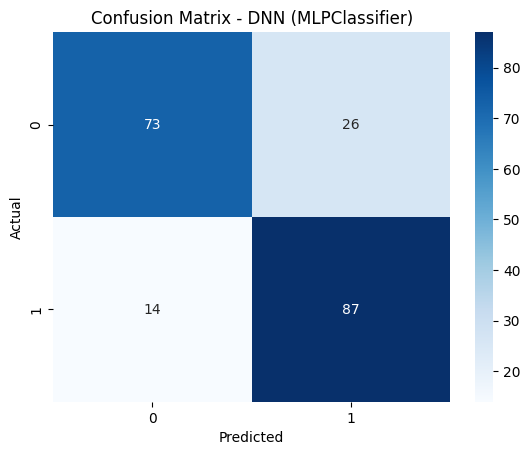

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_dnn), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - DNN (MLPClassifier)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**ROC and PR Curves**

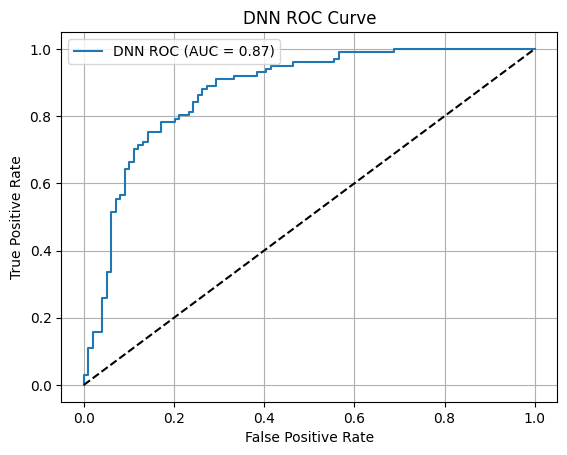

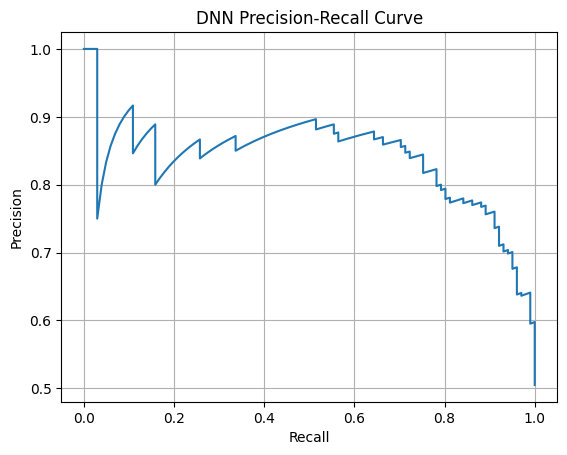

In [ ]:
# ROC
fpr, tpr, _ = roc_curve(y_test, y_dnn_proba)
plt.plot(fpr, tpr, label=f'DNN ROC (AUC = {dnn_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DNN ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# PR
precision, recall, _ = precision_recall_curve(y_test, y_dnn_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("DNN Precision-Recall Curve")
plt.grid(True)
plt.show()


**Calibration Curve**

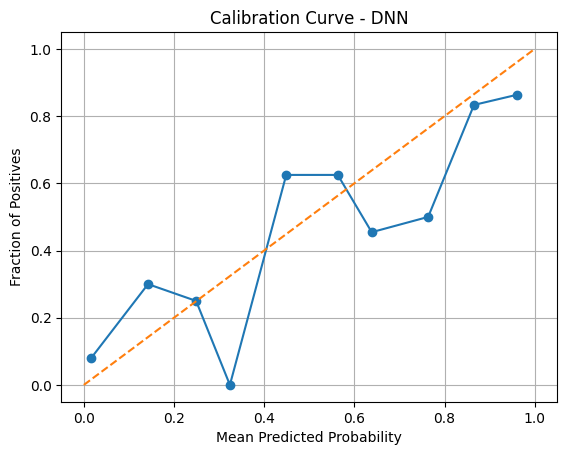

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, y_dnn_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Calibration Curve - DNN')
plt.grid(True)
plt.show()


**SHAP Explainability (Kernel Explainer for MLP)**

  0%|          | 0/100 [00:00<?, ?it/s]

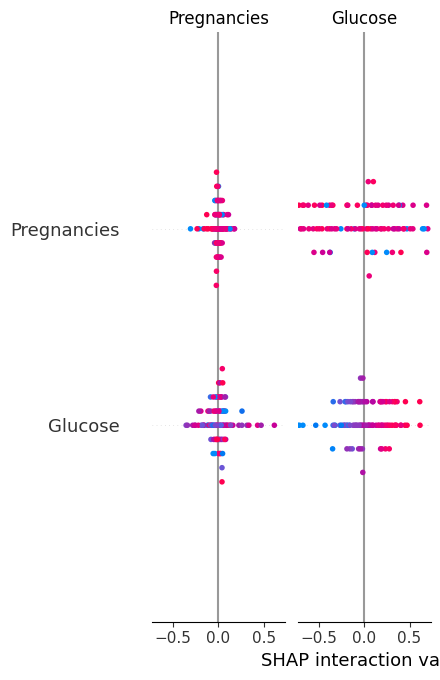

In [ ]:
import shap

# KernelExplainer for sklearn models
explainer = shap.KernelExplainer(dnn.predict_proba, shap.kmeans(X_train, 10))
shap_values = explainer.shap_values(X_test[:100])  # Limit to 100 samples to save time

shap.summary_plot(shap_values, X_test[:100], feature_names=df.drop("Outcome", axis=1).columns)


**Save DNN Model**

In [ ]:
joblib.dump(dnn, "dnn_diabetes_model.pkl")


['dnn_diabetes_model.pkl']

**TabNet Classifier (Deep Learning for Tabular Data)**

**Import and Initialize TabNet**

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier

tabnet = TabNetClassifier(seed=42)


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


**Train TabNet**

In [ ]:
tabnet.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=['auc'],
    max_epochs=200,
    patience=20,
    batch_size=128,
    virtual_batch_size=64,
    num_workers=0
)


epoch 0  | loss: 0.79665 | val_0_auc: 0.70787 |  0:00:00s
epoch 1  | loss: 0.5728  | val_0_auc: 0.76738 |  0:00:00s
epoch 2  | loss: 0.51315 | val_0_auc: 0.78078 |  0:00:01s
epoch 3  | loss: 0.4964  | val_0_auc: 0.77128 |  0:00:01s
epoch 4  | loss: 0.45368 | val_0_auc: 0.79208 |  0:00:01s
epoch 5  | loss: 0.45472 | val_0_auc: 0.78548 |  0:00:01s
epoch 6  | loss: 0.4627  | val_0_auc: 0.78728 |  0:00:02s
epoch 7  | loss: 0.43506 | val_0_auc: 0.78718 |  0:00:02s
epoch 8  | loss: 0.4611  | val_0_auc: 0.77978 |  0:00:02s
epoch 9  | loss: 0.42893 | val_0_auc: 0.78998 |  0:00:02s
epoch 10 | loss: 0.4669  | val_0_auc: 0.81548 |  0:00:02s
epoch 11 | loss: 0.44858 | val_0_auc: 0.80388 |  0:00:02s
epoch 12 | loss: 0.4422  | val_0_auc: 0.82448 |  0:00:03s
epoch 13 | loss: 0.40736 | val_0_auc: 0.82578 |  0:00:03s
epoch 14 | loss: 0.41867 | val_0_auc: 0.83088 |  0:00:03s
epoch 15 | loss: 0.40764 | val_0_auc: 0.82448 |  0:00:03s
epoch 16 | loss: 0.40998 | val_0_auc: 0.82408 |  0:00:03s
epoch 17 | los

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


**Predict with TabNet**

In [ ]:
y_tabnet = tabnet.predict(X_test)
y_tabnet_proba = tabnet.predict_proba(X_test)[:, 1]


**Evaluate TabNet**

In [ ]:
tabnet_acc = accuracy_score(y_test, y_tabnet)
tabnet_f1 = f1_score(y_test, y_tabnet)
tabnet_prec = precision_score(y_test, y_tabnet)
tabnet_recall = recall_score(y_test, y_tabnet)
tabnet_auc = roc_auc_score(y_test, y_tabnet_proba)
tabnet_brier = brier_score_loss(y_test, y_tabnet_proba)

print(f"Accuracy     : {tabnet_acc:.4f}")
print(f"F1 Score     : {tabnet_f1:.4f}")
print(f"Precision    : {tabnet_prec:.4f}")
print(f"Recall       : {tabnet_recall:.4f}")
print(f"AUC Score    : {tabnet_auc:.4f}")
print(f"Brier Score  : {tabnet_brier:.4f}")


Accuracy     : 0.7900
F1 Score     : 0.8190
Precision    : 0.7252
Recall       : 0.9406
AUC Score    : 0.8547
Brier Score  : 0.1570


**Confusion Matrix**

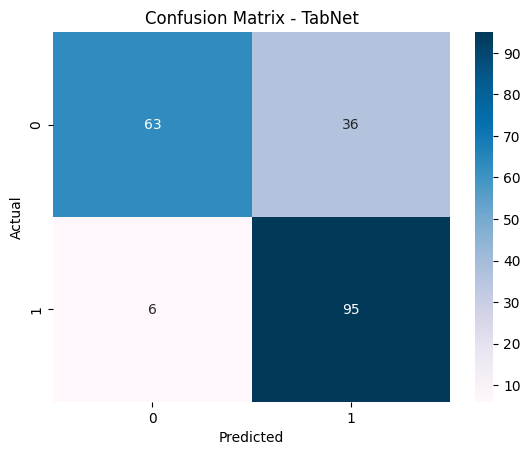

In [ ]:
sns.heatmap(confusion_matrix(y_test, y_tabnet), annot=True, fmt='d', cmap='PuBu')
plt.title("Confusion Matrix - TabNet")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


**ROC and Precision-Recall Curve**

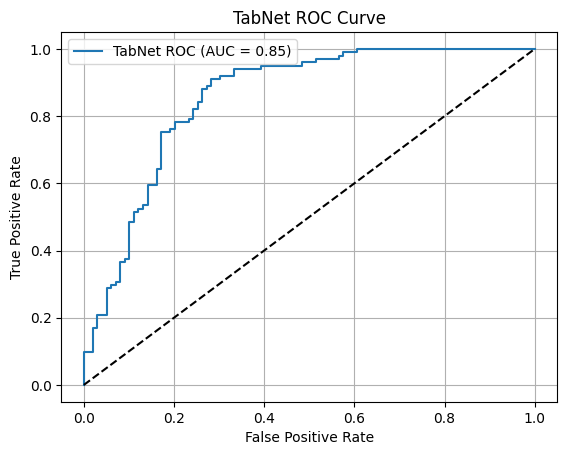

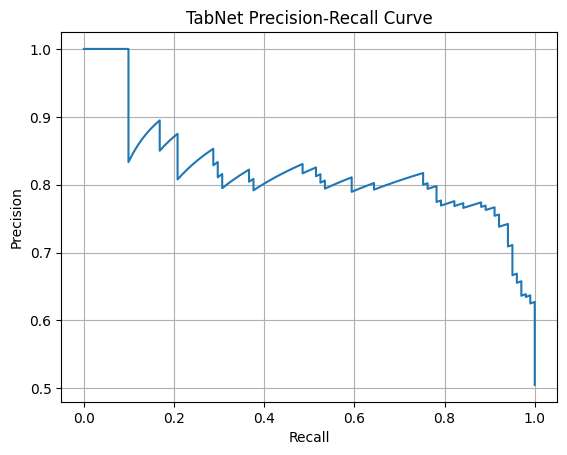

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_tabnet_proba)
plt.plot(fpr, tpr, label=f'TabNet ROC (AUC = {tabnet_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("TabNet ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_tabnet_proba)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("TabNet Precision-Recall Curve")
plt.grid(True)
plt.show()


**Calibration Curve**

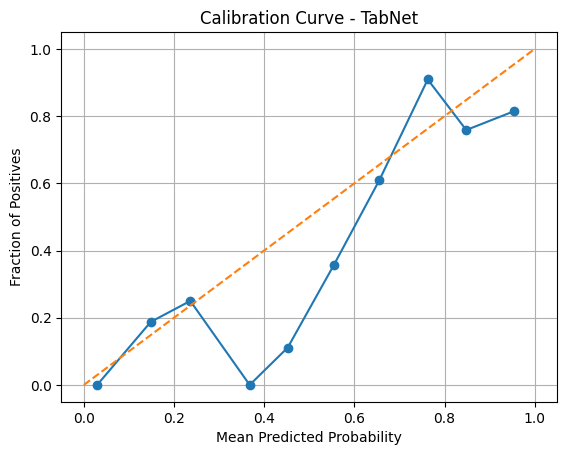

In [ ]:
prob_true, prob_pred = calibration_curve(y_test, y_tabnet_proba, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Curve - TabNet")
plt.grid(True)
plt.show()


**TabNet Feature Importances**

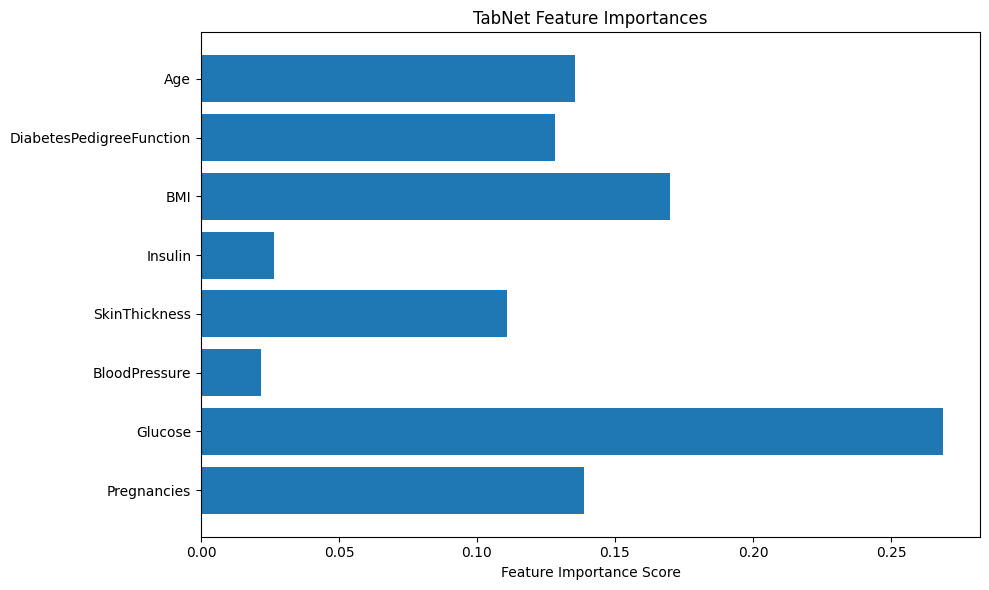

In [ ]:
# TabNet gives built-in feature importance
import numpy as np

feature_names = df.drop("Outcome", axis=1).columns
importances = tabnet.feature_importances_

plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance Score")
plt.title("TabNet Feature Importances")
plt.tight_layout()
plt.show()


**Save TabNet Model**

In [ ]:
import joblib
joblib.dump(tabnet, "tabnet_diabetes_model.pkl")


['tabnet_diabetes_model.pkl']

**Final Comparison of All Models**

In [ ]:
# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['KNN', 'BernoulliNB', 'Random Forest', 'XGBoost', 'DNN', 'TabNet'],
    'Accuracy': [knn_acc, bnb_acc, rf_acc, xgb_acc, dnn_acc, tabnet_acc],
    'F1 Score': [knn_f1, bnb_f1, rf_f1, xgb_f1, dnn_f1, tabnet_f1],
    'Precision': [knn_prec, bnb_prec, rf_prec, xgb_prec, dnn_prec, tabnet_prec],
    'Recall': [knn_recall, bnb_recall, rf_recall, xgb_recall, dnn_recall, tabnet_recall],
    'AUC Score': [knn_auc, bnb_auc, rf_auc, xgb_auc, dnn_auc, tabnet_auc],
    'Brier Score': [knn_brier, bnb_brier, rf_brier, xgb_brier, dnn_brier, tabnet_brier]
})

# Round values
comparison_df = comparison_df.round(4)
comparison_df


,Model,Accuracy,F1 Score,Precision,Recall,AUC Score,Brier Score
0,KNN,0.785,0.8072,0.7377,0.8911,0.8465,0.1643
1,BernoulliNB,0.695,0.7053,0.6887,0.7228,0.7804,0.1982
2,Random Forest,0.785,0.7943,0.7685,0.8218,0.8920,0.1334
3,XGBoost,0.795,0.8038,0.7778,0.8317,0.8547,0.1524
4,DNN,0.800,0.8131,0.7699,0.8614,0.8748,0.1463
5,TabNet,0.790,0.8190,0.7252,0.9406,0.8547,0.1570


**Plot Model Performance**

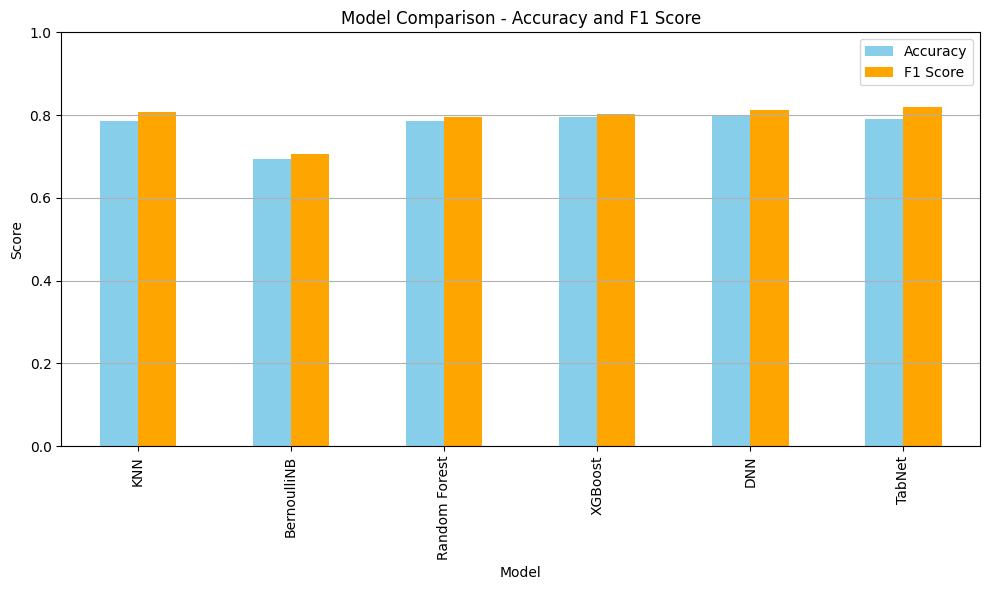

In [ ]:
# Plot Accuracy and F1 Score for all models
comparison_df.set_index('Model')[['Accuracy', 'F1 Score']].plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'])
plt.title("Model Comparison - Accuracy and F1 Score")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


**Patient Risk Profile Generator (SHAP-based Explanation per Patient)**

In [ ]:
import shap
import pandas as pd

# Convert X_test to DataFrame if it's not already
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Use SHAP
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test_df)

# Pick a patient (index 5 for example)
index = 5
shap.initjs()
shap.force_plot(explainer.expected_value,
                shap_values[index],
                X_test_df.iloc[index],
                feature_names=X.columns)


**Cohort Analysis – Which Groups Perform Best/Worst**

In [ ]:
import pandas as pd
from sklearn.metrics import f1_score

# Convert X_test back to DataFrame for indexing (if it's an array)
X_test_df = pd.DataFrame(X_test, columns=X.columns)

# Also reset index for y_test
y_test_series = pd.Series(y_test).reset_index(drop=True)

# Attach age to test set
X_test_df['Age'] = df.loc[X_test_df.index, 'Age'].values

# Create masks for test set only
older_mask = X_test_df['Age'] > 40
younger_mask = X_test_df['Age'] <= 40

# Predict
older_preds = xgb.predict(X_test[older_mask])
younger_preds = xgb.predict(X_test[younger_mask])

# Evaluate
print("F1 Score for Older Patients:", f1_score(y_test_series[older_mask], older_preds))
print("F1 Score for Younger Patients:", f1_score(y_test_series[younger_mask], younger_preds))


F1 Score for Older Patients: 0.8771929824561403
F1 Score for Younger Patients: 0.7763157894736842


**Risk-Adjusted Thresholding**

In [ ]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_xgb_proba)
f1_scores = 2 * precision * recall / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]
print("Optimal Threshold (F1-max):", best_threshold)

# Apply new threshold
y_xgb_thresh = (y_xgb_proba >= best_threshold).astype(int)
print("F1 at best threshold:", f1_score(y_test, y_xgb_thresh))


Optimal Threshold (F1-max): 0.29395798
F1 at best threshold: 0.8290598290598291


In [ ]:
import joblib

# Save trained XGBoost model
joblib.dump(xgb, "xgb_diabetes_model.pkl")

# Save your QuantileTransformer scaler
joblib.dump(scaler, "scaler.pkl")
